### Tensor

In [27]:
from __future__ import print_function
import torch

In [28]:
x = torch.empty(5, 3) # empty matrix
y = torch.rand(5, 3) # random matrix
z = torch.zeros(5, 3, dtype=torch.long) # matrix of zeros
a = torch.tensor([5.5, 3]) # matrix from list
b = x.new_ones(5, 3, dtype=torch.double) # matrix from existing tensor
c = torch.randn_like(x, dtype=torch.float) # matrix from existing tensor and override dtype

print(x)

tensor([[4.0680e-20, 1.9226e-42, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])


### Operation


In [29]:
z = torch.add(x, y)
print(z)
y.add_(x) # in-place addition
print(y)

tensor([[0.9783, 0.4847, 0.5051],
        [0.0494, 0.2981, 0.0850],
        [0.4582, 0.1977, 0.2458],
        [0.9661, 0.7454, 0.3484],
        [0.3670, 0.8352, 0.7343]])
tensor([[0.9783, 0.4847, 0.5051],
        [0.0494, 0.2981, 0.0850],
        [0.4582, 0.1977, 0.2458],
        [0.9661, 0.7454, 0.3484],
        [0.3670, 0.8352, 0.7343]])


### CUDA Tensor

In [30]:
if torch.cuda.is_available():
  device = torch.device("cuda") # Khởi tạo một cuda device object
  y = torch.ones_like(x, device = device) # Trực tiếp khởi tạo một tensor trên GPU
  x = x.to(device) # Truyền giá trị tensor vào thiết bị. Có thể truyền vào tên thiết bị: .to("cuda")
  z = x + y
  print(z)
  print(z.to("cpu", torch.double)) # Trong hàm .to() ta có thể thay định dạng dữ liệu.

### Autograd

In [31]:
x = torch.ones(2, 2, requires_grad=True)
print(x)
y = x + 2
print(y)
print(y.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [32]:
a = torch.ones(3, 3)
print(a)
a.requires_grad_(True)
b = (a*a).sum()
print(b)
print(b.grad_fn)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor(9., grad_fn=<SumBackward0>)


In [33]:
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [34]:
out.backward()
print(x.grad) # d(out)/dx

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [35]:
x = torch.randn(3, requires_grad=True)
yhat = torch.randn(3, requires_grad=True)*2
y = x*2
l = ((y-yhat)**2).mean()
print(l)


tensor(8.8995, grad_fn=<MeanBackward0>)


In [36]:
# v = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float).reshape(1, -1)
# l.backward(v)
# print(x.grad)

### CNN 

In [37]:
import torch.nn as nn
import torch.nn.functional as F

In [38]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(16*6*6, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [39]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [40]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [41]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0971, -0.0895,  0.0948,  0.0334,  0.0011, -0.0046, -0.0384, -0.1408,
          0.0893,  0.0870]], grad_fn=<AddmmBackward0>)


In [42]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### Loss Function

In [43]:
output = net(input)
target = torch.randn(10)
target = target.view(1, -1)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.3048, grad_fn=<MseLossBackward0>)


input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d -> view -> linear -> relu -> linear -> relu -> linear -> MSELoss -> loss

In [44]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

### Backpropagation

In [45]:
net.zero_grad()
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0018,  0.0043, -0.0051,  0.0085,  0.0065,  0.0100])


In [46]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001)

optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()

### CIFAR10

In [47]:
import torchvision
import torchvision.transforms as transforms

In [48]:
import torch
import torchvision
import torchvision.transforms as transforms

# Xây dựng một chuẩn hóa đầu vào cho ảnh

transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Khởi tạo dữ trainset qui định dữ liệu training
trainset = torchvision.datasets.CIFAR10(root = './CIFAR10', train = True, 
                                       download = True, transform = transform)

# Khởi tạo trainloader qui định cách truyền dữ liệu vào model theo batch. 
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, 
                                         shuffle = True, num_workers = 2)

# Tương tự nhưng đối với test
testset = torchvision.datasets.CIFAR10(root = './CIFAR10', train = False, 
                                      download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                              shuffle = False, num_workers = 2)

# Nhãn cho các class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


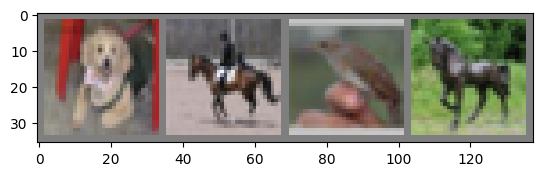

  dog horse  bird horse


In [49]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [50]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
net = Net()

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)

In [52]:
for epoch in range(2): # loop over the dataset multiple times
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs, data is a list of [inputs, labels]
    inputs, labels = data
    
    # zero the parameter gradients
    optimizer.zero_grad()
    
    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' %
           (epoch + 1, i + 1, running_loss/2000))
      running_loss = 0.0
      
print('Finished Training')

[1,  2000] loss: 2.302
[1,  4000] loss: 2.295
[1,  6000] loss: 2.275
[1,  8000] loss: 2.197
[1, 10000] loss: 2.086
[1, 12000] loss: 1.990
[2,  2000] loss: 1.931
[2,  4000] loss: 1.855
[2,  6000] loss: 1.822
[2,  8000] loss: 1.789
[2, 10000] loss: 1.730
[2, 12000] loss: 1.670
Finished Training


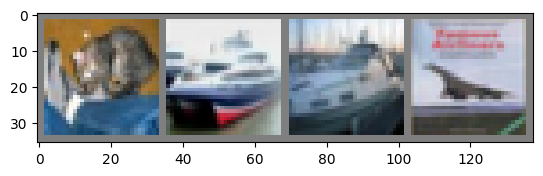

GroundTruth:   cat  ship  ship plane


In [54]:
# Sử dụng hàm iter để biến testloader thành 1 iterator, từ đó có thể lấy các giá trị tiếp theo.
dataiter = iter(testloader)
images, labels = next(dataiter)

# print image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: {}'.format(' '.join('%5s' % classes[labels[j]] for j in range(4))))

In [55]:
outputs = net(images)
print(type(outputs))
print(outputs.shape)


<class 'torch.Tensor'>
torch.Size([4, 10])


In [56]:
_,  predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  ship  ship  ship


In [57]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 38 %


In [58]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 44 %
Accuracy of  bird :  5 %
Accuracy of   cat : 14 %
Accuracy of  deer : 33 %
Accuracy of   dog : 22 %
Accuracy of  frog : 51 %
Accuracy of horse : 51 %
Accuracy of  ship : 58 %
Accuracy of truck : 52 %
